In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=5

#### Loading Data

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [18]:
len(dataset) # as dataset is divided into batches

68

In [19]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 1 1 0 2 0 1 0 0 0 2 2 0 2 1 0 1 2 0 1 0 0 0 0 0 0 1]


#### Visualizing data

In [20]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch[0].shape)

[[[169. 163. 165.]
  [173. 167. 169.]
  [162. 156. 158.]
  ...
  [170. 168. 173.]
  [194. 192. 197.]
  [187. 185. 190.]]

 [[166. 160. 162.]
  [171. 165. 167.]
  [163. 157. 159.]
  ...
  [172. 170. 175.]
  [182. 180. 185.]
  [181. 179. 184.]]

 [[161. 155. 157.]
  [168. 162. 164.]
  [161. 155. 157.]
  ...
  [180. 178. 183.]
  [173. 171. 176.]
  [181. 179. 184.]]

 ...

 [[113. 102. 106.]
  [117. 106. 110.]
  [116. 105. 109.]
  ...
  [170. 164. 168.]
  [167. 161. 165.]
  [148. 142. 146.]]

 [[122. 111. 115.]
  [148. 137. 141.]
  [107.  96. 100.]
  ...
  [152. 146. 150.]
  [149. 143. 147.]
  [147. 141. 145.]]

 [[118. 107. 111.]
  [128. 117. 121.]
  [125. 114. 118.]
  ...
  [161. 155. 159.]
  [123. 117. 121.]
  [183. 177. 181.]]]
(256, 256, 3)


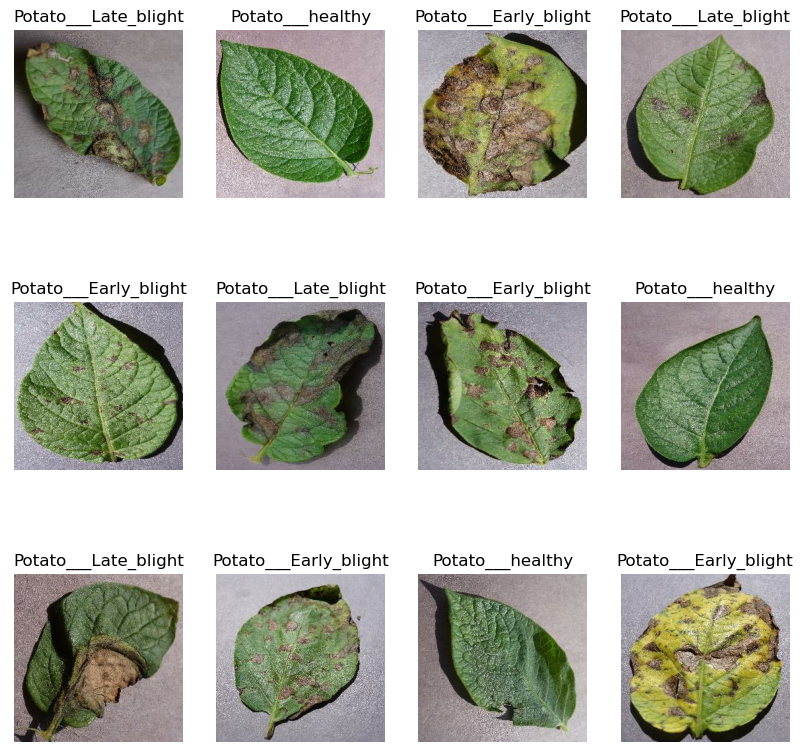

In [21]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

#### Train test split

In [22]:
#80%= training
#20%= 10% validation 10% test

In [23]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [24]:
train_ds = dataset.take(54)
len(train_ds)

54

In [25]:
test_ds= dataset.skip(54)
len(test_ds)

14

In [26]:
val_size=.1
len(dataset)*val_size

6.800000000000001

In [27]:
val_ds= test_ds.take(6)
test_ds = test_ds.skip(6)

In [28]:
def get_dataset_partitions_tf(ds,train_split=.8, val_split=.1,test_split=.1,shuffle=True, shuffle_size= 10000):
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size = int(len(ds)*train_split)
    val_size = int(len(ds)*val_split)
    train_ds = ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,test_ds,val_ds

In [29]:
train_ds,test_ds,val_ds = get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds),len(test_ds),len(val_ds),

(54, 8, 6)

#### Data preprocessing

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [33]:
#data_aug = tf.keras.Sequential([
#    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2)
#])

#### Model Building

In [34]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential ([
    resize_and_rescale,
    #data_aug,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
      
])
model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
history = model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/5
54/54 [==============================] - 317s 6s/step - loss: 0.8958 - accuracy: 0.5006 - val_loss: 0.7827 - val_accuracy: 0.5833
Epoch 2/5
54/54 [==============================] - 95s 2s/step - loss: 0.6543 - accuracy: 0.7106 - val_loss: 0.4651 - val_accuracy: 0.8333
Epoch 3/5
54/54 [==============================] - 91s 2s/step - loss: 0.4284 - accuracy: 0.8194 - val_loss: 0.3633 - val_accuracy: 0.8490
Epoch 4/5
54/54 [==============================] - 104s 2s/step - loss: 0.2825 - accuracy: 0.8970 - val_loss: 0.2821 - val_accuracy: 0.9010
Epoch 5/5
54/54 [==============================] - 123s 2s/step - loss: 0.2319 - accuracy: 0.9115 - val_loss: 0.2609 - val_accuracy: 0.8906


In [37]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 12s 398ms/step - loss: 0.1900 - accuracy: 0.9141


In [38]:
 scores

[0.1899789273738861, 0.9140625]

In [39]:
history

In [40]:
history.params 

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
history.history['accuracy']

[0.5005787014961243,
 0.7106481194496155,
 0.8194444179534912,
 0.8969907164573669,
 0.9114583134651184]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

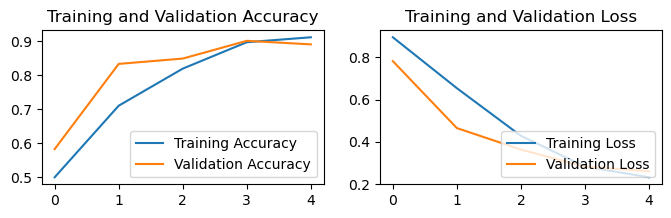

In [44]:
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc= "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc= "lower right")
plt.title("Training and Validation Loss")

#### Model Prediction

first image to predict
first_images actual label :  Potato___Late_blight
first_images predicted label :  Potato___Late_blight


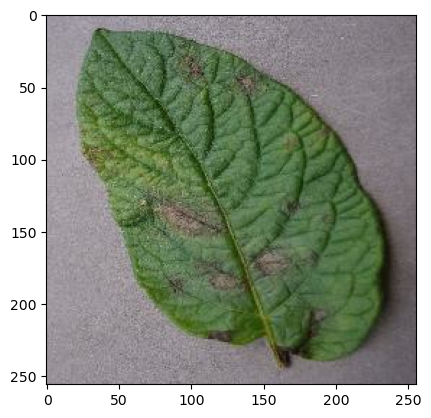

In [45]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print('first_images actual label : ',class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print('first_images predicted label : ',class_names[np.argmax(batch_prediction[0])])
  

In [46]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence  = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

C:\Users\saras\AppData\Local\Temp\ipykernel_22632\1364904873.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,i+1)


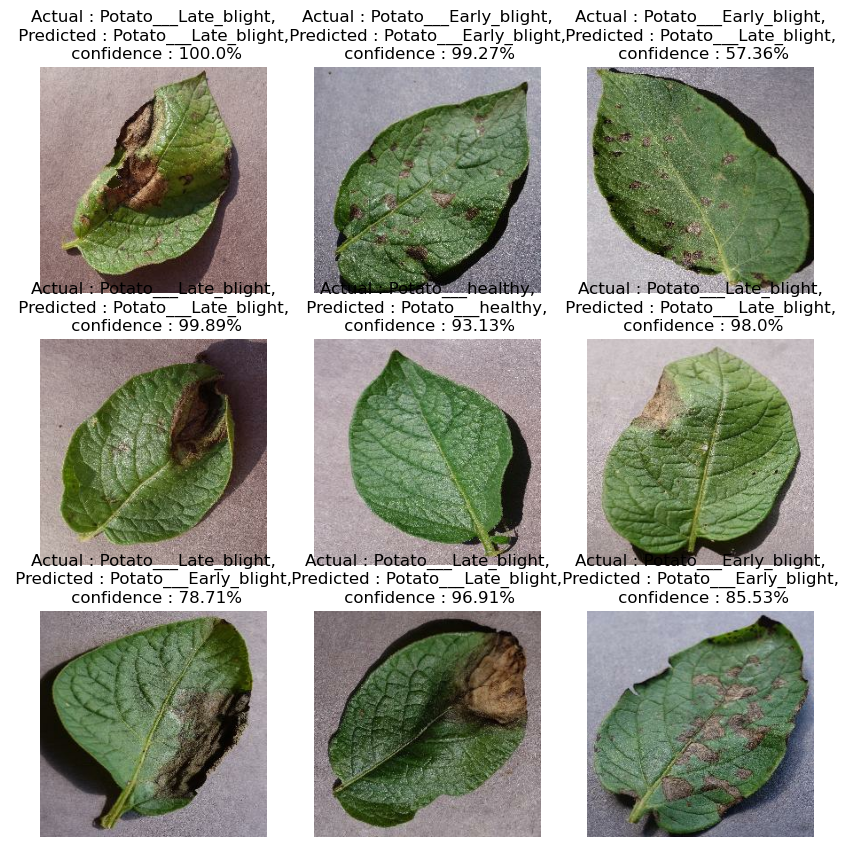

In [47]:
plt.figure(figsize=(10,10))
for images,labels in test_ds.take(2):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.axis("off")
        predicted_class,confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}, \n confidence : {confidence}%")

In [49]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
